# Train Like Bonito
https://github.com/nanoporetech/bonito/blob/master/notebooks/bonito-train.ipynb

In [1]:
import os
import sys
import time
import random
from datetime import datetime
from itertools import starmap
from pathlib import Path

import numpy as np
import pandas as pd
import toml
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from bonito.util import accuracy
from bonito.training import ChunkDataSet
from bonito.decode import decode, decode_ref

import timeit
import matplotlib.pyplot as plt
import fastai.basics as fastai

In [2]:
!cd ../../../mapped_reads/bonito_preprocessed/; ls

data  mapped_reads.hdf5


In [3]:
base_dir = Path("../../../mapped_reads/bonito_preprocessed/")
def load_np(fn): return np.load(base_dir/'data'/fn)
#def load_toml(fn): return toml.load(base_dir/'config'/fn)

In [4]:
# Sections of squiggle that correspond with the target reference sequence
# Variable length and zero padded (upto 4096 samples).
# shape (1000000, 4096)
# dtype('float32')
full_chunks = load_np("chunks.npy")

# Lengths of squiggle sections in chunks.npy 
# shape (1000000,)
# dtype('uint16')
full_chunk_lengths = load_np("chunk_lengths.npy")

# Integer encoded target sequence {'A': 1, 'C': 2, 'G': 3, 'T': 4}
# Variable length and zero padded (default range between 128 and 256).
# shape (1000000, 256)
# dtype('uint8')
full_targets = load_np("references.npy")

# Lengths of target sequences in references.npy
# shape (1000000,)
# dtype('uint8')
full_target_lengths = load_np("reference_lengths.npy")

In [5]:
# The structure of the model is defined using a config file.
# This will make sense to those familar with QuartzNet
# https://arxiv.org/pdf/1910.10261.pdf).
quartznet_config = toml.load("train_like_bonito/quartznet5x5.toml")

In [53]:
from torch.nn import ReLU, LeakyReLU, GELU
from torch.nn import Module, ModuleList, Sequential, Conv1d, BatchNorm1d, Dropout

activations = {
    "relu": ReLU,
    "leaky_relu": LeakyReLU,
    "gelu": GELU,
}


class Model(Module):
    """
    Model template for QuartzNet style architectures

    https://arxiv.org/pdf/1910.10261.pdf
    """
    def __init__(self, config):
        super(Model, self).__init__()
        self.stride = config['block'][0]['stride'][0]
        self.alphabet = config['labels']['labels']
        self.features = config['block'][-1]['filters']
        self.encoder = Encoder(config)
        self.decoder = Decoder(self.features, len(self.alphabet))

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


class Encoder(nn.Module):
    """
    Builds the model encoder
    """
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config

        features = self.config['input']['features']
        activation = activations[self.config['encoder']['activation']]()
        encoder_layers = []

        for layer in self.config['block']:
            encoder_layers.append(
                Block(
                    features, layer['filters'], activation,
                    repeat=layer['repeat'], kernel_size=layer['kernel'],
                    stride=layer['stride'], dilation=layer['dilation'],
                    dropout=layer['dropout'], residual=layer['residual'],
                    separable=layer['separable'], groups=layer['groups'], 
                    shuffle=layer['shuffle']
                )
            )

            features = layer['filters']

        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x):
        return self.encoder([x])
    

class TCSConv1d(Module):
    """
    Time-Channel Separable 1D Convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, shuffle=False, bias=False, separable=False):

        super(TCSConv1d, self).__init__()
        self.separable = separable
        self.groups = groups
        self.shuffle = shuffle
        
        if groups > 1 and not separable:
            raise ValueError("Grouping should probably only be used with separable kernels.")

        if separable:
            self.depthwise = Conv1d(
                in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                padding=padding, dilation=dilation, bias=bias, groups=in_channels
            )

            self.pointwise = Conv1d(
                in_channels, out_channels, kernel_size=1, stride=stride,
                dilation=dilation, bias=bias, padding=0, groups=groups
            )
        else:
            self.conv = Conv1d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation, bias=bias
            )

    def forward(self, x):
        if self.separable:
            
            x = self.depthwise(x)
            
            #_optimize(True)
            x = self.pointwise(x)
            #_optimize(False)
        else:
            x = self.conv(x)
        
        if self.shuffle and self.groups > 1:
            x = _shuffle_channels(x, self.groups)
        
        return x


class Block(nn.Module):
    """
    TCSConv, Batch Normalisation, Activation, Dropout
    """
    def __init__(self, in_channels, out_channels, activation, repeat=5, kernel_size=1, stride=1, dilation=1,
                 dropout=0.0, residual=False, separable=False, groups=1, shuffle=False):

        super(Block, self).__init__()

        self.use_res = residual
        self.conv = nn.ModuleList()

        _in_channels = in_channels
        padding = _get_padding(kernel_size[0], stride[0], dilation[0], _in_channels)

        # add the first n - 1 convolutions + activation
        for _ in range(repeat - 1):
            self.conv.extend(
                self.get_tcs(
                    _in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, dilation=dilation,
                    padding=padding, separable=separable,
                    groups=groups, shuffle=shuffle
                )
            )

            self.conv.extend(self.get_activation(activation, dropout))
            _in_channels = out_channels

        # add the last conv and batch norm
        self.conv.extend(
            self.get_tcs(
                _in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, dilation=dilation,
                padding=padding, separable=separable
            )
        )

        # add the residual connection
        if self.use_res:
            self.residual = nn.Sequential(*self.get_tcs(in_channels, out_channels))

        # add the activation and dropout
        self.activation = nn.Sequential(*self.get_activation(activation, dropout))

    def get_activation(self, activation, dropout):
        return activation, nn.Dropout(p=dropout)

    def get_tcs(self, in_channels, out_channels, kernel_size=1, stride=1, dilation=1, padding=0, bias=False, separable=False, groups=1, shuffle=False):
        return [
            TCSConv1d(
                in_channels, out_channels, kernel_size,
                stride=stride, dilation=dilation, padding=padding,
                bias=bias, separable=separable, groups=groups, 
                shuffle=shuffle
            ),
            nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.1)
        ]

    def forward(self, x):
        _x = x[0]
        for layer in self.conv:
            _x = layer(_x)
        if self.use_res:
            _x += self.residual(x[0])
        return [self.activation(_x)]


class Decoder(Module):
    """
    Decoder
    """
    def __init__(self, features, classes):
        super(Decoder, self).__init__()
        self.layers = Sequential(Conv1d(features, classes, kernel_size=1, bias=True))

    def forward(self, x):
        x = self.layers(x[-1])
        return nn.functional.log_softmax(x.transpose(1, 2), dim=2)
    

def _shuffle_channels(x: torch.Tensor, groups:int) -> torch.Tensor:
    # Based on ShuffleNet: https://arxiv.org/abs/1707.01083 with this particular implementation:
    # https://github.com/pytorch/vision/blob/d6ee8757eca7b74b98e5f0d434a565eb7b1c410b/torchvision/models/shufflenetv2.py#L19
    batchsize, num_channels, feature_count = x.data.size()
    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups,
               channels_per_group, feature_count)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, feature_count)

    return x

def _get_padding(kernel_size, stride, dilation, features):
    
    # https://www.quora.com/How-can-I-calculate-the-size-of-output-of-convolutional-layer
    if stride == 1 and kernel_size%2 == 0:
        raise ValueError(f"stride of ({stride}) and even sized kernel ({kernel_size}) cannot be padded to retain input size")

    #Dilation simulates an increased kernel size (where we ignore the zeros)
    #This means that kernel_size 5 and dilation 1 is similiar to kernel size 3 and dilation 2 regardig how much to pad
    features = features-1

    dilated_kernel_size = kernel_size+(kernel_size-1)*(dilation-1)
    padding = (dilated_kernel_size+features*stride-features)//2

    return padding


def _optimize(value):
    torch.backends.cudnn.benchmark = value
    torch.backends.cudnn.deterministic = not value

#### Training options
Default options are set, and ranges are sensible, but most combinations of settings are untested.

The default settings will train on a small amount of data (1000 signal chunks) for a small number of epochs (20). This is unlikely to produce an accurate generalisable model, but will train relatively quickly.

After modifying this cell, Runtime -> Run after, so that all cells between this one and the main train looping will be run in accordance with new setting.

A train_proportion of 0.90 will use 90% of the data for training and 10% for validation.

No dropout is applied by default, but in order to avoid overfitting on small data sets it may be necessary to apply dropout (e.g. of 0.5), or other regularisation techniques.

In [41]:
model_savepath = Path("train_like_bonito/models")
learning_rate = 0.001 #@param {type:"number"}
random_seed = 25 #@param {type:"integer"}
epochs = 20 #@param {type:"slider", min:1, max:1000, step:1}
batch_size = 16 #@param [2, 4, 8, 16, 28] {type:"raw"}
num_chunks = 10000 #@param [10, 100, 1000, 10000, 100000] {type:"raw"}
train_proportion = 0.80 #@param type:"slider", min:0.8, max:1000, step:1
dropout = 0.0 #@param {type:"slider", min:0.0, max:0.8}

In [42]:
# Initialise random libs and setup cudnn
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# we exploit GPU for training
device = torch.device("cuda")

#### Prepare data according to values set in the 'Training options

In [9]:
# subset
chunks = full_chunks[:num_chunks]
chunk_lengths = full_chunk_lengths[:num_chunks]
targets = full_targets[:num_chunks]
target_lengths = full_target_lengths[:num_chunks]

# shuffle
shuf = np.random.permutation(chunks.shape[0])
chunks = chunks[shuf]
chunk_lengths = chunk_lengths[shuf]
targets = targets[shuf]
target_lengths = target_lengths[shuf]

split = np.floor(chunks.shape[0] * train_proportion).astype(np.int32)

In [10]:
for b in quartznet_config['block']:
    b['dropout'] = dropout
quartznet_config

{'model': 'QuartzNet',
 'labels': {'labels': ['N', 'A', 'C', 'G', 'T']},
 'input': {'features': 1},
 'encoder': {'activation': 'relu'},
 'block': [{'filters': 256,
   'repeat': 1,
   'kernel': [33],
   'stride': [3],
   'dilation': [1],
   'dropout': 0.0,
   'residual': False,
   'separable': False,
   'groups': 1,
   'shuffle': False},
  {'filters': 256,
   'repeat': 5,
   'kernel': [33],
   'stride': [1],
   'dilation': [1],
   'dropout': 0.0,
   'residual': True,
   'separable': True,
   'groups': 1,
   'shuffle': False},
  {'filters': 256,
   'repeat': 5,
   'kernel': [39],
   'stride': [1],
   'dilation': [1],
   'dropout': 0.0,
   'residual': True,
   'separable': True,
   'groups': 1,
   'shuffle': False},
  {'filters': 512,
   'repeat': 5,
   'kernel': [51],
   'stride': [1],
   'dilation': [1],
   'dropout': 0.0,
   'residual': True,
   'separable': True,
   'groups': 1,
   'shuffle': False},
  {'filters': 512,
   'repeat': 5,
   'kernel': [63],
   'stride': [1],
   'dilation'

In [23]:
groups = 1
shuffle = False
dilation = 1

In [24]:
def update_b_blocks(groups=1, shuffle=False, dilation=1):
    for b_block in quartznet_config['block'][1:-2]:
        b_block['groups'] = groups
        b_block['shuffle'] = shuffle
        b_block['dilation'] = [dilation]
update_b_blocks(groups, shuffle, dilation)

## Training and test functions

In [13]:
# 'Connectionist Temporal Classification' (CTC) loss fuction
# https://distill.pub/2017/ctc/
criterion = nn.CTCLoss(reduction='mean')

def train(log_interval, model, device, train_loader,
          optimizer, epoch, use_amp=False):

    t0 = time.perf_counter()
    chunks = 0

    model.train()

    sys.stderr.write("\n" + "Training epoch: " + str(epoch) + "\n")
    progress_bar = tqdm(total=len(train_loader), leave=True, ncols=100)

    for batch_idx, (data, out_lengths, target, lengths) in enumerate(train_loader, start=1):

        optimizer.zero_grad()

        chunks += data.shape[0]

        data = data.to(device)
        target = target.to(device)
        
        
        print(data.shape)

        # forward pass
        log_probs = model(data)    

        # calculate loss
        loss = criterion(log_probs.transpose(0, 1), target, out_lengths / model.stride, lengths)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        progress_bar.refresh()
        progress_bar.update(1)
        progress_bar.set_description("Loss: " + str(loss.item()))
        sys.stderr.flush()        

    progress_bar.close()

    return loss.item(), time.perf_counter() - t0


def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    predictions = []
    prediction_lengths = []

    with torch.no_grad():
        for batch_idx, (data, out_lengths, target, lengths) in enumerate(test_loader, start=1):
            data, target = data.to(device), target.to(device)
 
            # forward pass
            log_probs = model(data)
 
            # calculate loss
            test_loss += criterion(log_probs.transpose(1, 0), target, out_lengths / model.stride, lengths)

            # accumulate output probabilities
            predictions.append(torch.exp(log_probs).cpu())
            prediction_lengths.append(out_lengths / model.stride)

    predictions = np.concatenate(predictions)
    lengths = np.concatenate(prediction_lengths)

    # convert probabilities to sequences
    references = [decode_ref(target, model.alphabet) for target in test_loader.dataset.targets]
    sequences = [decode(post[:n], model.alphabet) for post, n in zip(predictions, lengths)]

    # align predicted sequences with true sequences and calculate accuracy
    if all(map(len, sequences)):
        accuracies = list(starmap(accuracy, zip(references, sequences)))
    else:
        accuracies = [0]

    # measure average accuracies over entire set of validation chunks
    mean = np.mean(accuracies)
    median = np.median(accuracies)

    return test_loss.item() / batch_idx, mean, median

## Main Training Loop

In [14]:
#@title Set experiment name
experiment_name = 'bonito_group_speed_09' #@param {type:"string"}

In [15]:
model = Model(quartznet_config)
model.to(device);

In [65]:
# data generators
train_dataset = ChunkDataSet(chunks[:split], chunk_lengths[:split],
                             targets[:split], target_lengths[:split])
test_dataset = ChunkDataSet(chunks[split:], chunk_lengths[split:],
                            targets[split:], target_lengths[split:])

# data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         num_workers=4, pin_memory=True)

In [35]:
# prevent overwriting of data
workdir = os.path.join(model_savepath, experiment_name)
if os.path.isdir(workdir):
    raise IOError('{} already exists. Select an alternative model_savepath.'.format(workdir))
os.makedirs(workdir)

# load bonito model

model.train()

# set optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), amsgrad=True, lr=learning_rate)
schedular = CosineAnnealingLR(optimizer, epochs * len(train_loader))

# report loss every 
interval = 500 / num_chunks
log_interval = np.floor(len(train_dataset) / batch_size * interval)

exp_config = os.path.join(workdir, "experimental.log")
with open(exp_config, 'a') as c:
    c.write('Num training chunks: {}'.format(num_chunks) + '\n')
    c.write('learning rate: {}'.format(learning_rate) + '\n')
    c.write('random seed: {}'.format(random_seed) + '\n')
    c.write('epochs: {}'.format(epochs) + '\n')
    c.write('batch_size: {}'.format(batch_size) + '\n')
    c.write('train proportion: {}'.format(train_proportion) + '\n')
    c.write('dropout: {}'.format(dropout) + '\n')

# DataFrame to store training logging information
training_results = pd.DataFrame()

for epoch in range(1, epochs + 1):

    train_loss, duration = train(log_interval, model, device,
                                 train_loader, optimizer, epoch)
    
    test_loss, mean, median = test(model, device, test_loader)

    # collate training and validation metrics
    epoch_result = pd.DataFrame(
        {'time':[datetime.today()],
         'duration':[int(duration)],
         'epoch':[epoch],
         'train_loss':[train_loss],
         'validation_loss':[test_loss], 
         'validation_mean':[mean],
         'validation_median':[median]})
    
    # save model weights
    weights_path = os.path.join(workdir, "weights_%s.tar" % epoch)
    torch.save(model.state_dict(), weights_path)

    # update log file
    log_path = os.path.join(workdir, "training.log")
    epoch_result.to_csv(log_path, mode='a', sep='\t', index=False)

    display(epoch_result)
    training_results = training_results.append(epoch_result)

    schedular.step()

display(training_results)


Training epoch: 1
  0%|                                                                       | 0/500 [00:00<?, ?it/s]

torch.Size([16, 1, 4800])


Loss: 2.961521625518799:   0%|                                      | 1/500 [00:01<11:29,  1.38s/it]

torch.Size([16, 1, 4800])


Loss: 2.003586530685425:   0%|▏                                     | 2/500 [00:01<08:35,  1.04s/it]

torch.Size([16, 1, 4800])


Loss: 2.0410923957824707:   1%|▏                                    | 3/500 [00:01<06:32,  1.27it/s]

torch.Size([16, 1, 4800])


Loss: 1.6267279386520386:   1%|▎                                    | 4/500 [00:02<05:07,  1.62it/s]

torch.Size([16, 1, 4800])


Loss: 1.4644328355789185:   1%|▎                                    | 5/500 [00:02<04:07,  2.00it/s]

torch.Size([16, 1, 4800])


Loss: 1.4674056768417358:   1%|▍                                    | 6/500 [00:02<03:25,  2.41it/s]

torch.Size([16, 1, 4800])


Loss: 1.464836835861206:   1%|▌                                     | 7/500 [00:02<02:55,  2.80it/s]

torch.Size([16, 1, 4800])


Loss: 1.436331033706665:   2%|▌                                     | 8/500 [00:02<02:35,  3.17it/s]

torch.Size([16, 1, 4800])


Loss: 1.4427924156188965:   2%|▋                                    | 9/500 [00:03<02:20,  3.49it/s]

torch.Size([16, 1, 4800])


Loss: 1.4461475610733032:   2%|▋                                   | 10/500 [00:03<02:10,  3.76it/s]

torch.Size([16, 1, 4800])


Loss: 1.4446666240692139:   2%|▊                                   | 11/500 [00:03<02:02,  3.99it/s]

torch.Size([16, 1, 4800])


Loss: 1.444615125656128:   2%|▉                                    | 12/500 [00:03<01:57,  4.15it/s]

torch.Size([16, 1, 4800])


Loss: 1.4495823383331299:   3%|▉                                   | 13/500 [00:04<01:53,  4.27it/s]

torch.Size([16, 1, 4800])


Loss: 1.4615522623062134:   3%|█                                   | 14/500 [00:04<01:51,  4.35it/s]

torch.Size([16, 1, 4800])


Loss: 1.4258508682250977:   3%|█                                   | 15/500 [00:04<01:49,  4.43it/s]

torch.Size([16, 1, 4800])


Loss: 1.4400893449783325:   3%|█▏                                  | 16/500 [00:04<01:48,  4.47it/s]

torch.Size([16, 1, 4800])


Loss: 1.4485135078430176:   3%|█▏                                  | 17/500 [00:04<01:47,  4.51it/s]

torch.Size([16, 1, 4800])


KeyboardInterrupt: 

## Tries (after 1 epoch): 

With Kaiming:

1: 0.9324800968170166

2: 0.9282790422439575

Without Kaiming:

1: 0.7507233619689941

Without Kaiming, dropout=0.5:

1: 1.2488034963607788

I am unsure why the runs differ with same settings when we use seed.

## Grouping experiments

## Not grouped:
Loss: 0.7371149063110352: 100%|███████████████████████████████████| 500/500 [01:50<00:00,  4.56it/s]

In [15]:
# Groups = 1
sum(p.numel() for p in model.parameters())

6678533

### Separable grouped in 2, no shuffle
Loss: 0.7065932154655457: 100%|███████████████████████████████████| 500/500 [01:41<00:00,  4.92it/s]

In [27]:
# Groups = 2
sum(p.numel() for p in model.parameters())

4909061

### Separable are grouped in 4
Loss: 0.7064507007598877: 100%|███████████████████████████████████| 500/500 [01:38<00:00,  5.15it/s]

In [14]:
# Groups = 4
sum(p.numel() for p in model.parameters())

4024325

### Sep grouped in 8, shuffle
Loss: 0.7681609392166138: 100%|███████████████████████████████████| 500/500 [01:38<00:00,  5.08it/s]

In [14]:
# Groups = 8
sum(p.numel() for p in model.parameters())

3581957

### Sep grouped in 16, shuffle
Loss: 0.8004525899887085: 100%|███████████████████████████████████| 500/500 [01:44<00:00,  4.79it/s]

In [23]:
# Groups = 16
sum(p.numel() for p in model.parameters())

3360773

### Sep grouped in 32, shuffle
Loss: 0.7854756116867065: 100%|███████████████████████████████████| 500/500 [01:57<00:00,  4.27it/s]

In [17]:
# Groups = 32
sum(p.numel() for p in model.parameters())

3250181

In [47]:
x = [1, 2, 4, 8, 16, 32]
y = [6678533, 4909061, 4024325, 3581957, 3360773, 3250181]

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


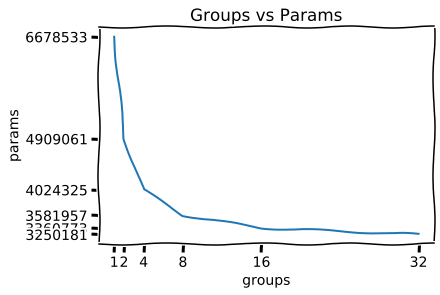

In [48]:
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.xticks(x, x)
    plt.yticks(y, y)
    ax.plot(x, y)
    ax.set(xlabel='groups', ylabel='params', title="Groups vs Params")
    plt.show()

In [49]:
y_speed = [110, 101, 98, 98, 104, 117]

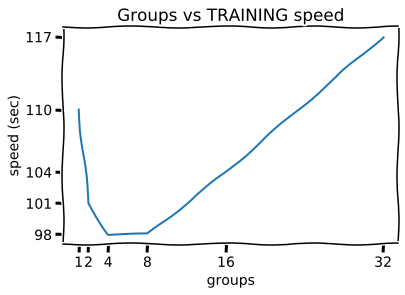

In [50]:
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.xticks(x, x)
    plt.yticks(y_speed, y_speed)
    ax.plot(x, y_speed)
    ax.set(xlabel='groups', ylabel='speed (sec)', title="Groups vs TRAINING speed")
    plt.show()

## Prediction speed

In [21]:
groups_used = [1, 2, 4, 8, 16, 32, 64, 128]
pred_speed = [48.4114401768893, 45.369062575511634, 42.66044902522117, 42.50363404955715, 43.516314630396664, 46.24883870314807, 52.164553365670145, 64.85917824413627]

In [72]:
data = torch.tensor(train_dataset[0:16][0]).cuda()

In [73]:
data.shape

torch.Size([16, 1, 4800])

In [44]:
shuffle = True
for gp in range(8):
    groups = 2**gp
    shuffle = True
    
    update_b_blocks(groups, shuffle)
    
    model = Model(quartznet_config).to(device)
    
    sum(p.numel() for p in model.parameters())
    
    #time = timeit.timeit(lambda: model(data), number=1000)
    #groups_used.append(groups)
    #pred_speed.append(time)
    #print(time)

48.4114401768893
45.369062575511634
42.66044902522117
42.50363404955715
43.516314630396664
46.24883870314807
52.164553365670145
64.85917824413627


In [52]:
groups_used

[1, 2, 4, 8, 16, 32, 64, 128]

In [53]:
pred_speed

[48.4114401768893,
 45.369062575511634,
 42.66044902522117,
 42.50363404955715,
 43.516314630396664,
 46.24883870314807,
 52.164553365670145,
 64.85917824413627]

In [56]:
x = groups_used; y_speed = pred_speed

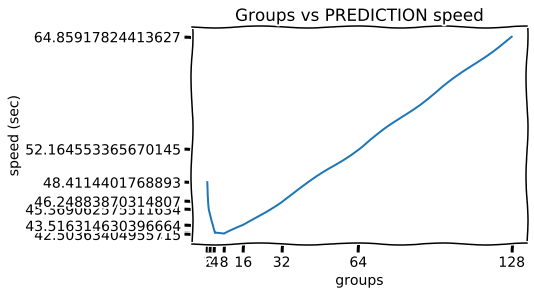

In [58]:
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.xticks(x, x)
    plt.yticks(y_speed, y_speed)
    ax.plot(x, y_speed)
    ax.set(xlabel='groups', ylabel='speed (sec)', title="Groups vs PREDICTION speed")
    plt.show()

In [26]:
def time_model_prediction(model, device, count=100, optimize=True):
    def _optimize(value):
        torch.backends.cudnn.benchmark = value
        torch.backends.cudnn.deterministic = not value
        
    signal = torch.ones(64, 1, 4800, device=device)
    #_optimize(optimize)
    if isinstance(model, fastai.Learner):
        fn = lambda: 
    fn = lambda: model(signal).detach().cpu()
    time = timeit.timeit(fn, number=count)
    return time

In [37]:
time_model_prediction(Model(quartznet_config).cuda(), "cuda")

18.958640524186194

In [45]:
time_model_prediction(Model(quartznet_config).cuda(), "cuda")

18.96796314883977

In [46]:
update_b_blocks(dilation=2)

In [47]:
time_model_prediction(Model(quartznet_config).cuda(), "cuda")

25.7103317854926

In [27]:
res_groups = []
res_times = []

for gp in tqdm(range(8)):
    groups = 2**gp
    shuffle = True
    
    update_b_blocks(groups, shuffle, dilation=2)
    
    model = Model(quartznet_config).to(device)
    
    regular_time = time_model_prediction(model, torch.device("cuda"), optimize=False)
    optimized_time = time_model_prediction(model, torch.device("cuda"), optimize=True)
    
    res_groups.append(groups)
    res_times.append((regular_time, optimized_time))


100%|██████████| 8/8 [10:08<00:00, 76.04s/it] 


In [78]:
res_groups, res_times

([1, 2, 4, 8, 16, 32, 64, 128],
 [(19.093109160661697, 20.239255806431174),
  (17.480659175664186, 18.30026791896671),
  (16.40094829443842, 17.2123236740008),
  (16.052115293219686, 16.823745944537222),
  (16.01458014920354, 16.836542488075793),
  (16.150112312287092, 17.021656163968146),
  (16.96525176335126, 17.398953166790307),
  (18.60699254181236, 17.211790407076478)])

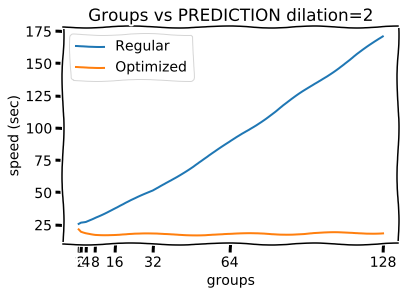

In [33]:
with plt.xkcd():
    fig, ax = plt.subplots()
    plt.xticks(res_groups, res_groups)
    line_reg, = plt.plot(res_groups, [reg for (reg, opt) in res_times], label='reg')
    line_opt, = plt.plot(res_groups, [opt for (reg, opt) in res_times], label='opt')
    plt.legend([line_reg, line_opt], ['Regular', "Optimized"])    
    
    ax.set(xlabel='groups', ylabel='speed (sec)', title="Groups vs PREDICTION dilation=2")
    
    plt.show()

## Does Fast.AI interfere with shuffling?

In [58]:
update_b_blocks(groups=2, shuffle=True)
shuffle_model = Model(quartznet_config).cuda()

In [61]:
update_b_blocks(groups=2, shuffle=False)
no_shuffle_model = Model(quartznet_config).cuda()

In [63]:
time_model_prediction(shuffle_model, "cuda", optimize=False)

17.435298836790025

In [62]:
time_model_prediction(no_shuffle_model, "cuda", optimize=False)

16.634081738069654

In [64]:
sum(p.numel() for p in shuffle_model.parameters()), sum(p.numel() for p in no_shuffle_model.parameters()) 

(4909061, 4909061)

In [67]:
databunch = fastai.DataBunch.create(train_dataset, test_dataset)

In [68]:
shuffle_learner = fastai.Learner(databunch, shuffle_model)

In [69]:
no_shuffle_learner = fastai.Learner(databunch, no_shuffle_model)

In [71]:
time_model_prediction(shuffle_learner, "cuda", optimize=False)

TypeError: 'Learner' object is not callable

In [76]:
shuffle_learner.summary()

AttributeError: 'ChunkDataSet' object has no attribute 'is_empty'

In [79]:
np.prod([2, 4, 12])

96

In [91]:
params = 0
for p in shuffle_learner.model.parameters():
    if p.requires_grad:
        params += p.numel()

In [93]:
params

4909061

In [94]:
import jkbc.model.factory as fac

In [96]:
configs = fac.grouping(quartznet_config)

KeyError: 'model_params'